# Réalisez une application de recommandation de contenu

In [6]:
import glob
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import timeit
import warnings
from azure.storage.blob import BlobServiceClient
from datetime import datetime
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

warnings.filterwarnings('ignore')
sns.set()

## Import des données

In [7]:
# metadata + embeddings des articles
NUM_EMBEDDINGS = 250

articles = pd.concat(
    [
        pd.read_csv(
            "dataset/articles_metadata.csv",
            parse_dates=["created_at_ts"],
            date_parser=lambda x: datetime.fromtimestamp(int(x) / 1000),
            dtype={
                "article_id": "category",
                "category_id": "category",
                "publisher_id": "category",
                "words_count": "int",
            },
        ),
        pd.DataFrame(
            pd.read_pickle("dataset/articles_embeddings.pickle"),
            columns=["embedding_" + str(i) for i in range(NUM_EMBEDDINGS)],
        ),
    ],
    axis=1,
)

articles = articles.astype({"created_at_ts": "datetime64[ns]"})
articles.drop(columns = ["created_at_ts", "publisher_id"], inplace = True)

In [8]:
# fichiers d'interactions
all_files = glob.glob("dataset/clicks/*.csv")
data = []
for filename in all_files:
    df = pd.read_csv(filename, parse_dates=["session_start", "click_timestamp"],
            date_parser=lambda x: datetime.fromtimestamp(int(int(x) / 1000)),
            index_col=None, header=0)
    data.append(df)

clicks = pd.concat(data, axis=0, ignore_index=True)

clicks = clicks.astype({"session_start": "datetime64[ns]", "click_timestamp": "datetime64[ns]"})

# indexage pour evaluation plus rapide
clicks = clicks.set_index('user_id')

Retirer les sujets qui ont trop peu d'interactions pour être pertinent

In [9]:
min_interaction = 20

print('Quantité d\'utilisateurs : {}'.format(len(clicks.index.unique())))
clicks['total_click'] = clicks.groupby(['user_id'])['click_article_id'].transform('count')
clicks = clicks[clicks['total_click'] >= min_interaction].reset_index()
clicks = clicks.set_index('user_id')
print('Quantité d\'utilisateurs avec au moins {} intéractions : {}'.format(min_interaction, len(clicks.index.unique())))

Quantité d'utilisateurs : 322897
Quantité d'utilisateurs avec au moins 20 intéractions : 35849


In [10]:
# regroupement des dataframes
data = {'clicks': clicks,
       'articles': articles}

## Evaluation

J'ai testé une évaluation de type HitRate, mais celle-ci était très lente (nottament sur le modèle CB_multiple qui effectue des predictions à partir de plusieurs articles de l'utilisateur) et optenait des résultats très faible. 
J'ai donc construit une evaluation qui compare :
- les categories des articles prédit par le modèle
- les categories d'articles les plus consommés par l'utilisateur

Il s'agit plus d'un indice de fiabilité que d'une evaluation

In [13]:
LENGHT_TOP_EVALUATION = 1000 # taille de la recommendation du modèle evalué

def ModelScore(data, model, lim = None):
    
    mean_score = 0 # score moyen qui sera notre indicateur
    amplitude_score = [1, 0] # score minimal et maximal qui seront des indicateurs secondaires
    
    # liste d'user a parcourir
    if (lim) :
        plage = random.sample(list(data['clicks'].index.unique().values), lim) # evaluation sur une fraction des users
    else:
        plage = list(data['clicks'].index.unique().values) # evaluation sur la totalité des users (très long)
    
    
    for idx, user in enumerate(plage):

        # classement des catégories de l'utilisateur
        articles_read = data['clicks'].loc[user]['click_article_id'].tolist()
        articles_read_embedding = data['articles'].loc[articles_read]
        counts = articles_read_embedding['category_id'].value_counts()
        freq = articles_read_embedding['category_id'].value_counts(normalize=True)
        user_catchy = pd.DataFrame({'count': counts, 'freq': freq})
        
        # model_recomandations
        reco = model.recommend_items(user, nb = LENGHT_TOP_EVALUATION)
        
        # calcul du score user
        score_for_user = 0
        reverse_i = 0
        somme_i = 0
        for i in range(LENGHT_TOP_EVALUATION, 0, -1):
            cat = reco['category_id'].loc[reverse_i]
            poids = user_catchy['freq'].loc[cat]
            score_for_user += i * poids
            somme_i += i
            reverse_i += 1
        
        score_for_user /= somme_i
        
        # update global score
        if score_for_user < amplitude_score[0]:
            amplitude_score[0] = score_for_user
        if score_for_user > amplitude_score[1]:
            amplitude_score[1] = score_for_user
        mean_score += score_for_user
                
    if (lim) :
        mean_score /= lim
    else:
        mean_score /= len(data['clicks'].index.unique())
        
    return mean_score, amplitude_score

## Model de popularité (model témoin)

In [7]:
# determinons les articles les plus populaires
pop_df = data['clicks'].copy()
pop_df['occurence'] = 1
pop_df = pop_df.groupby('click_article_id')['occurence'].sum().sort_values(ascending=False).reset_index()
pop_df

,click_article_id,occurence
0,160974,12584
1,272143,11693
2,336221,9919
3,336223,8955
4,234698,8831
...,...,...
26695,151696,1
26696,151711,1
26697,151712,1
26698,151774,1


In [8]:
class Popularity:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, data):
        self.popularity_df = popularity_df
        self.clicks = data['clicks']
        self.articles = data['articles']
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user, nb = 10):
        
        user_items = self.clicks.loc[user]['click_article_id'].tolist()
        
        reco = self.popularity_df[~self.popularity_df['click_article_id'].isin(user_items)] \
                               .sort_values('occurence', ascending = False).head(nb)
        
        reco = reco.reset_index().drop(columns=['index'])
        reco.rename(columns={'click_article_id': 'article_id'}, inplace = True)
        reco = reco.merge(self.articles['category_id'], how = 'left', left_on = 'article_id', right_index = True)

        return reco
    
popularity_model = Popularity(pop_df, data)

In [9]:
popularity_model.recommend_items(user = 5)

,article_id,occurence,category_id
0,272143,11693,399
1,336221,9919,437
2,336223,8955,437
3,234698,8831,375
4,123909,8776,250
5,96210,7832,209
6,183176,7466,301
7,331116,7208,436
8,199198,6867,323
9,272660,6847,399


## Recomandations content based

Je test 2 approches pour le content based
- une approche multi, qui fais une recherche d'articles similaires à plusieurs articles lu par l'user
- une approche mean, qui determine un 'profil' user en fesant la moyenne des embeddings de ses lectures et qui cherche ensuite les articles les plus similaires à ce profil

In [10]:
class ContentBased_multi:
    
    MODEL_NAME = 'Content-Based'
    CUT = 5000 # ne prend pas en compte les articles predits au dela pour alleger les calculs
    
    def __init__(self, data, etudes = 10):
        self.clicks = data['clicks']
        self.articles = data['articles']  
        self.ETUDES = etudes # nombres d'articles de l'user etudiés (les plus recents)
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def get_reco_from_one(self, article_id):
        # get the  similarity scores sorted with that article
        to_sim = self.articles.drop(columns=['article_id', 'category_id', 'words_count'])
        article_sim_scores = cosine_similarity(to_sim.iloc[article_id].values.reshape(1, -1), to_sim)
        article_sim_scores = [i for i in enumerate(article_sim_scores[0])]
        article_sim_scores = sorted(list(article_sim_scores), key=lambda x: x[1], reverse=True)
        article_sim_scores = article_sim_scores[1:self.CUT+1]
        
        # get the indices & scores
        reco_indices = [i[0] for i in article_sim_scores]
        scores = [i[1] for i in article_sim_scores]        
        
        # return as df
        reco_from_one_df = pd.DataFrame()
        reco_from_one_df['article_id'] = reco_indices
        reco_from_one_df['sim_scores'] = scores
        reco_from_one_df['ranking'] = range(1, len(reco_from_one_df) + 1)
    
        return reco_from_one_df, article_sim_scores

    def get_similar_items_to_user(self, user_items):
        user_scores = pd.DataFrame(self.articles['article_id'])
        user_scores['sim_scores'] = 0.0

        for article_id in user_items[-self.ETUDES:]:
            reco_from_this, _ = self.get_reco_from_one(article_id)
            # aggregate the scores
            user_scores = pd.concat([user_scores, reco_from_this[['article_id', 'sim_scores']]]).groupby(['article_id'], 
                                                    as_index=False).sum({'sim_scores'})
        user_scores['sim_scores'] /= self.ETUDES
        # sort and print the aggregated scores
        user_scores = user_scores.sort_values(by = 'sim_scores', ascending = False)
        return user_scores        
        
    def recommend_items(self, user, nb = 10):
        
        user_items = self.clicks.loc[user]['click_article_id'].tolist()
        
        similar_items = self.get_similar_items_to_user(user_items)
        
        similar_items_filtered = similar_items[~similar_items['article_id'].isin(user_items)].reset_index()
        reco = pd.DataFrame(similar_items_filtered, columns=['article_id', 'sim_scores']).head(nb)
        reco = reco.merge(self.articles['category_id'], how = 'left', left_on = 'article_id', right_index = True)

        return reco
    
cb_model_multi = ContentBased_multi(data)

In [11]:
cb_model_multi.recommend_items(user = 5)

,article_id,sim_scores,category_id
0,159582,0.349037,281
1,161453,0.345793,281
2,157169,0.343368,281
3,157463,0.342325,281
4,157735,0.341105,281
5,160659,0.340558,281
6,156928,0.340503,281
7,158660,0.340314,281
8,153303,0.339635,281
9,149835,0.339538,278


In [14]:
class ContentBased_mean:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, data):
        self.clicks = data['clicks']
        self.articles = data['articles']
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def get_user_profil(self, user):
        user_clicks = self.clicks.loc[user]['click_article_id'].tolist()
        user_catchy = self.articles.loc[user_clicks]
        user_profil = user_catchy.groupby(lambda x: user).mean()
        user_profil.drop(columns = ['words_count'], inplace = True)
        return user_profil

    def get_reco_from_profile(self, profile):
        # get the  similarity scores sorted with that article
        to_sim = self.articles.drop(columns=['article_id', 'category_id', 'words_count'])
        article_sim_scores = cosine_similarity(profile, to_sim)
        article_sim_scores = [i for i in enumerate(article_sim_scores[0])]
        article_sim_scores = sorted(list(article_sim_scores), key = lambda x: x[1], reverse = True)
        article_sim_scores = article_sim_scores[1:]
        
        #get the indices & scores
        reco_indices = [i[0] for i in article_sim_scores]
        scores = [i[1] for i in article_sim_scores]        
        
        # return as df
        reco_from_one_df = pd.DataFrame()
        reco_from_one_df['article_id'] = reco_indices
        reco_from_one_df['sim_scores'] = scores
        reco_from_one_df['ranking'] = range(1, len(reco_from_one_df) + 1)
    
        return reco_from_one_df  
        
    def recommend_items(self, user, nb = 10):
        
        profile = self.get_user_profil(user)      
        user_items = self.clicks.loc[user]['click_article_id'].tolist()
        
        suggestions = self.get_reco_from_profile(profile)
        
        suggestions_filtered = suggestions[~suggestions['article_id'].isin(user_items)].reset_index()
        reco = pd.DataFrame(suggestions_filtered, columns=['article_id', 'sim_scores']).head(nb)
        reco = reco.merge(self.articles['category_id'], how = 'left', left_on = 'article_id', right_index = True)

        return reco
    
cb_model_profile = ContentBased_mean(data)

In [12]:
cb_model_profile.recommend_items(5)

,article_id,sim_scores,category_id
0,285233,0.809752,412
1,280901,0.809310,412
2,345218,0.808173,440
3,286255,0.807334,412
4,284145,0.804384,412
5,285946,0.803266,412
6,283276,0.803032,412
7,203186,0.801977,327
8,281395,0.799600,412
9,282747,0.797539,412


## Model collaborative filtering

Le premier enjeu est de definir un rating score

In [15]:
def box_var(var, data):        
    sns.boxplot(x = data[var], palette = "deep")
    plt.show()
    display(pd.DataFrame(data[var].describe()))
    
def smooth_user_preference(x):
    return math.log(1+x, 2)

In [16]:
#par quantité d'interactions entres utilisateurs et articles
cf_interactions_df = data['clicks'].reset_index().copy()
cf_interactions_df['strength'] = 1
cf_interactions_df = cf_interactions_df.groupby(['user_id', 'click_article_id'])['strength'].sum() \
                    .apply(smooth_user_preference).reset_index()
cf_interactions_df.head()

,user_id,click_article_id,strength
0,5,36399,1.584963
1,5,42612,1.000000
2,5,50405,1.000000
3,5,50494,1.000000
4,5,50864,1.000000


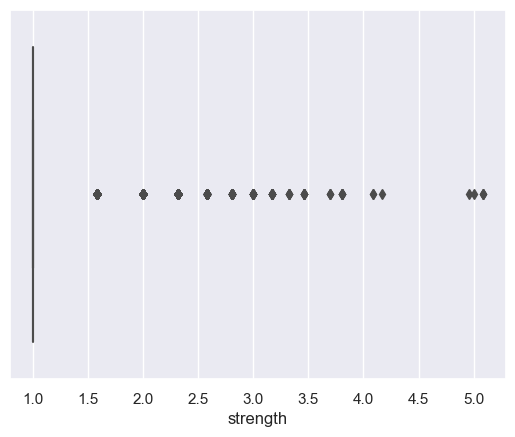

,strength
count,1.363264e+06
mean,1.011565e+00
std,8.794443e-02
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,5.087463e+00


In [16]:
box_var('strength', cf_interactions_df)

Remarque, il y a très peu d'interractions reproduites : + de 3/4 des interractions utilisateur / article sont unitaires, notre score pourraient en être déséquilibré

In [8]:
#par temps passé sur l'articles
cf_duration_df = data['clicks'].reset_index().copy()
cf_duration_df['duration'] = cf_duration_df['click_timestamp'] - cf_duration_df['session_start']
cf_duration_df['strength'] = [td.seconds  for td in cf_duration_df['duration']]
cf_duration_df = cf_duration_df.groupby(['user_id', 'click_article_id'])['strength'].sum() \
                    .apply(smooth_user_preference).reset_index()
cf_duration_df.head()

,user_id,click_article_id,strength
0,5,36399,8.082149
1,5,42612,5.392317
2,5,50405,10.007027
3,5,50494,9.199672
4,5,50864,10.486835


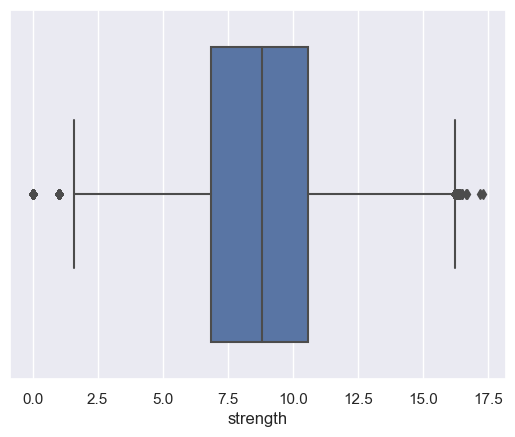

,strength
count,1.363264e+06
mean,8.750220e+00
std,2.671558e+00
min,0.000000e+00
25%,6.845490e+00
50%,8.804131e+00
75%,1.059619e+01
max,1.733166e+01


In [18]:
box_var('strength', cf_duration_df)

La répartition du score lié à la durée passé sur les articles est plus echelloné 

In [17]:
# construction de la matrice users/articles des interactions
pivot_matrix_df = cf_interactions_df.pivot(index = 'user_id', columns = 'click_article_id', values = 'strength').fillna(0)
pivot_matrix_df

click_article_id,27,115,137,139,143,145,258,267,289,291,...,363978,363982,363984,363992,364001,364012,364013,364015,364017,364043
user_id,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
315667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
316121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
pivot_matrix = pivot_matrix_df.values
users_ids = list(pivot_matrix_df.index)

pivot_sparse_matrix = csr_matrix(pivot_matrix)
pivot_sparse_matrix

<35849x26700 sparse matrix of type '<class 'numpy.float64'>'
	with 1363264 stored elements in Compressed Sparse Row format>

In [19]:
NUMBER_OF_FACTORS_MF = 15
U, sigma, Vt = svds(pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)
sigma = np.diag(sigma)

In [20]:
all_user_predictions = np.dot(np.dot(U, sigma), Vt) 
all_user_predictions = (all_user_predictions - all_user_predictions.min()) / (all_user_predictions.max() - all_user_predictions.min())
cf_interactions_final = pd.DataFrame(all_user_predictions, columns = pivot_matrix_df.columns, index = users_ids).transpose()
cf_interactions_final

,5,6,7,8,10,11,12,16,17,19,...,308772,310654,313176,314941,315007,315483,315667,316121,319538,321475
click_article_id,,,,,,,,,,,,,,,,,,,,,
27,0.250032,0.250021,0.250019,0.250021,0.250025,0.250025,0.250017,0.250021,0.250025,0.250013,...,0.250020,0.250023,0.250022,0.250022,0.250018,0.250018,0.250022,0.250021,0.250021,0.250021
115,0.250114,0.250206,0.250020,0.250087,0.250020,0.250074,0.250051,0.250037,0.250032,0.249976,...,0.250052,0.250058,0.250053,0.250050,0.250085,0.250088,0.250054,0.250096,0.250055,0.250021
137,0.250012,0.250022,0.250043,0.250056,0.250010,0.250031,0.250015,0.250043,0.250052,0.250044,...,0.250028,0.249997,0.250029,0.250006,0.249989,0.249989,0.250010,0.249986,0.250006,0.250021
139,0.250034,0.250070,0.250010,0.250033,0.249993,0.250014,0.250044,0.250003,0.250000,0.250009,...,0.250043,0.250067,0.250029,0.250062,0.250098,0.250103,0.250059,0.250099,0.250064,0.250021
143,0.250012,0.250022,0.250043,0.250056,0.250010,0.250031,0.250015,0.250043,0.250052,0.250044,...,0.250028,0.249997,0.250029,0.250006,0.249989,0.249989,0.250010,0.249986,0.250006,0.250021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364012,0.250048,0.249980,0.250060,0.250065,0.250024,0.250006,0.250085,0.250034,0.250051,0.250025,...,0.250054,0.250093,0.250030,0.250089,0.250136,0.250139,0.250085,0.250137,0.250094,0.250021
364013,0.250048,0.249980,0.250060,0.250065,0.250024,0.250006,0.250085,0.250034,0.250051,0.250025,...,0.250054,0.250093,0.250030,0.250089,0.250136,0.250139,0.250085,0.250137,0.250094,0.250021
364015,0.250048,0.249980,0.250060,0.250065,0.250024,0.250006,0.250085,0.250034,0.250051,0.250025,...,0.250054,0.250093,0.250030,0.250089,0.250136,0.250139,0.250085,0.250137,0.250094,0.250021


In [11]:
# construction de la matrice users/articles des durations
pivot_matrix_df = cf_duration_df.pivot(index = 'user_id', columns = 'click_article_id', values = 'strength').fillna(0)
pivot_matrix = pivot_matrix_df.values
users_ids = list(pivot_matrix_df.index)
pivot_sparse_matrix = csr_matrix(pivot_matrix)
U, sigma, Vt = svds(pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)
sigma = np.diag(sigma)
all_user_predictions = np.dot(np.dot(U, sigma), Vt) 
all_user_predictions = (all_user_predictions - all_user_predictions.min()) / (all_user_predictions.max() - all_user_predictions.min())
cf_duration_final = pd.DataFrame(all_user_predictions, columns = pivot_matrix_df.columns, index = users_ids).transpose()
cf_duration_final

,5,6,7,8,10,11,12,16,17,19,...,308772,310654,313176,314941,315007,315483,315667,316121,319538,321475
click_article_id,,,,,,,,,,,,,,,,,,,,,
27,0.344697,0.344689,0.344687,0.344689,0.344694,0.344691,0.344685,0.344686,0.344689,0.344688,...,0.344689,0.344691,0.344691,0.344690,0.344688,0.344688,0.344690,0.344690,0.344689,0.344689
115,0.344795,0.344791,0.344654,0.344709,0.344718,0.344745,0.344658,0.344766,0.344755,0.344668,...,0.344721,0.344734,0.344772,0.344732,0.344761,0.344791,0.344746,0.344775,0.344745,0.344689
137,0.344683,0.344690,0.344698,0.344702,0.344685,0.344695,0.344686,0.344702,0.344703,0.344698,...,0.344692,0.344681,0.344697,0.344684,0.344676,0.344672,0.344685,0.344676,0.344681,0.344689
139,0.344693,0.344763,0.344638,0.344703,0.344655,0.344702,0.344670,0.344639,0.344632,0.344696,...,0.344714,0.344734,0.344726,0.344728,0.344779,0.344817,0.344737,0.344780,0.344745,0.344689
143,0.344689,0.344689,0.344689,0.344689,0.344689,0.344689,0.344689,0.344689,0.344689,0.344689,...,0.344689,0.344689,0.344689,0.344689,0.344689,0.344689,0.344689,0.344689,0.344689,0.344689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364012,0.344738,0.344645,0.344759,0.344768,0.344700,0.344673,0.344759,0.344695,0.344744,0.344691,...,0.344737,0.344786,0.344711,0.344781,0.344887,0.344947,0.344802,0.344874,0.344836,0.344689
364013,0.344738,0.344644,0.344759,0.344768,0.344700,0.344673,0.344759,0.344695,0.344745,0.344691,...,0.344738,0.344787,0.344711,0.344782,0.344888,0.344948,0.344803,0.344875,0.344836,0.344689
364015,0.344738,0.344645,0.344759,0.344768,0.344700,0.344673,0.344759,0.344695,0.344744,0.344691,...,0.344737,0.344786,0.344711,0.344781,0.344887,0.344947,0.344802,0.344874,0.344836,0.344689


In [21]:
class CollaborativeFiltering:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_preds_df, data):
        self.predictions = cf_preds_df
        self.articles = data['articles']
        self.clicks = data['clicks']
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user, nb = 10):     
        
        user_items = self.clicks.loc[user]['click_article_id'].tolist()
        
        sorted_predictions = self.predictions[user].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user: 'strength'})

        reco = sorted_predictions[~sorted_predictions['click_article_id'].isin(user_items)] \
                                .sort_values('strength', ascending = False) \
                                .reset_index().drop(columns=['index']).head(nb)
        reco.rename(columns={'click_article_id': 'article_id'}, inplace = True)
        reco = reco.merge(self.articles['category_id'], how = 'left', left_on = 'article_id', right_index = True)

        return reco
    
cf_model_interactions = CollaborativeFiltering(cf_interactions_final, data)
cf_model_duration = CollaborativeFiltering(cf_duration_final, data)

In [25]:
cf_model_interactions.recommend_items(user = 5)

,article_id,strength,category_id
0,158536,0.350827,281
1,160417,0.340978,281
2,156560,0.336590,281
3,289003,0.314787,418
4,159762,0.313992,281
5,161506,0.307042,281
6,183176,0.301228,301
7,235854,0.300038,375
8,156624,0.298210,281
9,331116,0.298091,436


In [26]:
cf_model_duration.recommend_items(user = 5)

,article_id,strength,category_id
0,158536,0.431651,281
1,156560,0.416185,281
2,160417,0.415589,281
3,183176,0.404016,301
4,331116,0.401308,436
5,289003,0.398706,418
6,161506,0.393644,281
7,336254,0.390732,437
8,157478,0.389688,281
9,202355,0.386721,327


## Model Hybrid

On peux construire une modèle hybride qui combinera les approches de 2 modèles

In [22]:
class Hybrid:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_model, cf_model, data, cb_weight = 1.0, cf_weight = 1.0):
        self.cb = cb_model
        self.cf = cf_model
        self.cb_weight = cb_weight
        self.cf_weight = cf_weight
        self.articles = data['articles']
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user, nb = 10):
               
        NB = 100 * nb
        # getting the top Content-based filtering recommendations
        cb_reco_df = self.cb.recommend_items(user, nb = NB) \
        .rename(columns = {'sim_scores': 'strength_CB'}).drop(columns = ['category_id'])
        
        # getting the top Collaborative filtering recommendations
        cf_reco_df = self.cf.recommend_items(user, nb = NB) \
        .rename(columns = {'strength': 'strength_CF'}).drop(columns = ['category_id'])
        
        # combining the results by contentId
        reco_df = cb_reco_df.merge(cf_reco_df,
                                   how = 'outer', 
                                   left_on = 'article_id', 
                                   right_on = 'article_id').fillna(0.0)
        
        # computing a hybrid recommendation score based on CF and CB scores
        reco_df['strength_Hybrid'] = (reco_df['strength_CB'] * self.cb_weight) \
                                     + (reco_df['strength_CF'] * self.cf_weight)
        
        # sorting recommendations by hybrid score
        reco = reco_df.sort_values('strength_Hybrid', ascending = False) \
        .reset_index().drop(columns=['index']).head(nb)
        reco = reco.merge(self.articles['category_id'], how = 'left', left_on = 'article_id', right_index = True)
     
        return reco
    
hybrid_model = Hybrid(cb_model_profile, cf_model_interactions, data, cb_weight = 1.0, cf_weight = 1.0)

In [28]:
hybrid_model.recommend_items(use = 5)

,article_id,strength_CB,strength_CF,strength_Hybrid,category_id
0,205873,0.785447,0.258230,1.043677,331
1,284705,0.783764,0.254935,1.038699,412
2,285719,0.766582,0.270560,1.037142,412
3,285045,0.751628,0.256380,1.008008,412
4,160453,0.743103,0.264125,1.007228,281
5,284491,0.749524,0.255720,1.005243,412
6,283608,0.750947,0.253202,1.004149,412
7,286161,0.729472,0.273345,1.002817,412
8,285101,0.739009,0.254263,0.993271,412
9,207760,0.736770,0.255272,0.992042,331


## Tests

In [23]:
def confront(grid, eval_lim = 1000):
    comparateur = pd.DataFrame(columns = ['category_id_Score', 'min_score', 'max_score', 'EXE time'])

    for g in grid:
        print(g)
        start_time = timeit.default_timer()
        cat_score, ampli = ModelScore(data, grid[g], lim = eval_lim)
        elapsed = timeit.default_timer() - start_time
        print(elapsed)
        time = round(elapsed, 2)
        res_to_df = pd.DataFrame([[cat_score, ampli[0], ampli[1], time]],
                                index=[g],
                                columns = ['category_id_Score', 'min_score', 'max_score', 'EXE time'])
        comparateur = comparateur.append(res_to_df)

    return comparateur

In [31]:
grid = {}
grid['Popularity'] = Popularity(pop_df, data)
for e in [10, 50, 100]:
    grid['CB_multi_etudes_'+str(e)] = ContentBased_multi(data, etudes = e)
grid['CB_mean'] = ContentBased_mean(data)
grid['CF_interactions'] = CollaborativeFiltering(cf_interactions_final, data)
grid['CF_duration'] = CollaborativeFiltering(cf_duration_final, data)
grid

{'Popularity': <__main__.Popularity at 0x1eb07f11370>,
 'CB_multi_etudes_10': <__main__.ContentBased_multi at 0x1eb07f112e0>,
 'CB_multi_etudes_50': <__main__.ContentBased_multi at 0x1eb07f11400>,
 'CB_multi_etudes_100': <__main__.ContentBased_multi at 0x1eb07f111f0>,
 'CB_mean': <__main__.ContentBased_mean at 0x1eb07f11340>,
 'CF_interactions': <__main__.CollaborativeFiltering at 0x1eb07f11310>,
 'CF_duration': <__main__.CollaborativeFiltering at 0x1eb07f11040>}

In [32]:
# test rapide de 5 users par modèle
test5 = confront(grid, eval_lim = 5) 

Popularity
0.3066748999999902
CB_multi_etudes_10
77.57881850000004
CB_multi_etudes_50
277.00485999999995
CB_multi_etudes_100
231.08147169999995
CB_mean
8.634260799999993
CF_interactions
0.3904758999999558
CF_duration
0.39303639999991447


In [33]:
test5

,category_id_Score,min_score,max_score,EXE time
Popularity,0.040399,0.025065,0.051458,0.31
CB_multi_etudes_10,0.103717,0.027117,0.331690,77.58
CB_multi_etudes_50,0.178776,0.099417,0.273156,277.00
CB_multi_etudes_100,0.152048,0.054105,0.287702,231.08
CB_mean,0.151757,0.058590,0.256526,8.63
CF_interactions,0.057143,0.034666,0.077082,0.39
CF_duration,0.038473,0.008152,0.058377,0.39


In [34]:
# test de 100 users par modèle
test100 = confront(grid, eval_lim = 100) 

Popularity
6.709453999999937
CB_multi_etudes_10
1534.2927826999999
CB_multi_etudes_50
5004.1652572
CB_multi_etudes_100
5962.0757853
CB_mean
171.83457760000056
CF_interactions
5.986227700001109
CF_duration
7.096868299999187


In [35]:
test100

,category_id_Score,min_score,max_score,EXE time
Popularity,0.038715,0.006078,0.075551,6.71
CB_multi_etudes_10,0.138412,0.006770,0.790245,1534.29
CB_multi_etudes_50,0.198139,0.017749,0.793313,5004.17
CB_multi_etudes_100,0.167150,0.016078,0.666043,5962.08
CB_mean,0.134114,0.022560,0.645183,171.83
CF_interactions,0.047533,0.020702,0.162850,5.99
CF_duration,0.045831,0.011971,0.124636,7.10


On remarque bien l'ecart de temps d'exécution pour les modèles CB_multi même à etudes = 10, 
le score laisse penser que les récommandations sont les plus pertinentes mais leurs temps de calculs sont moins adaptés à un deploiement cloud.

Les CF sont très rapide à fournir leurs recommendations et celles-ci semblent nettement au dessus du modèle témoin

Le CB_mean semble bien equilibré, de bons résultats et un temps d'execution acceptable

In [25]:
grid2 = {}
for w in [0.5, 1, 1.5, 2, 3]:
    grid2['Hybrid_'+str(w)] = Hybrid(grid['CB_mean'], grid['CF_interactions'], data, cb_weight = 1.0, cf_weight = w)
grid2

{'Hybrid_0.5': <__main__.Hybrid at 0x144ca714880>,
 'Hybrid_1': <__main__.Hybrid at 0x144ca714760>,
 'Hybrid_1.5': <__main__.Hybrid at 0x144e623e5b0>,
 'Hybrid_2': <__main__.Hybrid at 0x144e623ed60>,
 'Hybrid_3': <__main__.Hybrid at 0x144e623ee80>}

In [26]:
# test rapide de 5 users par modèle
test5 = confront(grid2, eval_lim = 5) 

Hybrid_0.5
10.11692499999981
Hybrid_1
9.634096299999783
Hybrid_1.5
9.674047599999994
Hybrid_2
9.672776700000213
Hybrid_3
9.603315199999997


In [27]:
test5

,category_id_Score,min_score,max_score,EXE time
Hybrid_0.5,0.133324,0.035391,0.206529,10.12
Hybrid_1,0.084176,0.071722,0.112431,9.63
Hybrid_1.5,0.183581,0.043968,0.470676,9.67
Hybrid_2,0.087703,0.048429,0.146184,9.67
Hybrid_3,0.151431,0.020910,0.254085,9.60


In [53]:
# test de 1000 users par modèle
test1000 = confront(grid2, eval_lim = 1000) 

Hybrid_0.5
1804.1064479999986
Hybrid_1
1803.2151234000012
Hybrid_1.5
1802.472443499999
Hybrid_2
1803.9320703000012
Hybrid_3
1805.1095256000008


In [54]:
test1000

,category_id_Score,min_score,max_score,EXE time
Hybrid_0.5,0.132521,0.019276,0.875256,1804.11
Hybrid_1,0.122052,0.015070,0.848616,1803.22
Hybrid_1.5,0.118367,0.012478,0.736797,1802.47
Hybrid_2,0.122623,0.012020,0.625064,1803.93
Hybrid_3,0.120943,0.020619,0.673194,1805.11


### Data look

In [ ]:
data['clicks']

In [ ]:
data["articles"]

## Upload to Azure blob storage

In [14]:
connect_str = "DefaultEndpointsProtocol=https;AccountName=p9teststockage;AccountKey=AI0GHZZor7+Sg6MxDQvBoL1NtdEMhQA3mqxB98r+I3Oj6fZ/B3oeQ44uW/2SJxP/4XA4xfyqbs/X+ASti4jVPg==;EndpointSuffix=core.windows.net"
blob_service_client = BlobServiceClient.from_connection_string(connect_str)

In [36]:
# réduction du df clicks
clicks = data['clicks'].reset_index()
clicks = clicks[['user_id', 'click_article_id']]

In [37]:
output = clicks.to_csv(index=False, encoding="utf-8")
upload_file_path = "P9_chaleyssin_nicolas/clicks"
blob_client = blob_service_client.get_blob_client(container="dftoblob", blob=upload_file_path)
blob_client.upload_blob(output, blob_type="BlockBlob")

{'etag': '"0x8DB08F34710C1A7"',
 'last_modified': datetime.datetime(2023, 2, 7, 10, 8, 36, tzinfo=datetime.timezone.utc),
 'content_md5': bytearray(b'&_\x05\xfd\xfe0=Q=\n{F\xa0 ]\xf6'),
 'client_request_id': '5d0d1af7-a6cf-11ed-bdf3-00155dd3cb12',
 'request_id': '7d6336d9-801e-0004-48dc-3a95a7000000',
 'version': '2021-08-06',
 'version_id': None,
 'date': datetime.datetime(2023, 2, 7, 10, 8, 35, tzinfo=datetime.timezone.utc),
 'request_server_encrypted': True,
 'encryption_key_sha256': None,
 'encryption_scope': None}

In [40]:
#Réduction du df articles via PCA
only_embedding = data["articles"].iloc[:,3:]
pca = PCA(n_components=75)
pca.fit(only_embedding)
embedding_pca = pca.transform(only_embedding)
embedding_pca = pd.DataFrame(embedding_pca, 
                                      columns = ["embedding_" + str(i) for i in range(embedding_pca.shape[1])])
articles = data["articles"].iloc[:,:1].merge(embedding_pca, how = 'left', right_index = True, left_index = True)
sum(pca.explained_variance_ratio_)

0.9800583633392728

In [42]:
output = articles.to_csv(index=False, encoding="utf-8")
upload_file_path = "P9_chaleyssin_nicolas/articles"
blob_client = blob_service_client.get_blob_client(container="dftoblob", blob=upload_file_path)
blob_client.upload_blob(output, blob_type="BlockBlob")

{'etag': '"0x8DB08F406D3B3E2"',
 'last_modified': datetime.datetime(2023, 2, 7, 10, 13, 58, tzinfo=datetime.timezone.utc),
 'content_md5': None,
 'content_crc64': bytearray(b'\x91\xd4c\x11K.\xa5\xe3'),
 'client_request_id': '226396af-a6d0-11ed-b5bc-00155dd3cb12',
 'request_id': '7d661371-801e-0004-41dc-3a95a7000000',
 'version': '2021-08-06',
 'version_id': None,
 'date': datetime.datetime(2023, 2, 7, 10, 13, 57, tzinfo=datetime.timezone.utc),
 'request_server_encrypted': True,
 'encryption_key_sha256': None,
 'encryption_scope': None}

In [ ]:
# Envoi du cf_duration pour proposer un modèle hybride ?

In [ ]:
output = cf_duration_final.to_csv(index=False, encoding="utf-8")
upload_file_path = "P9_chaleyssin_nicolas/duration"
blob_client = blob_service_client.get_blob_client(container="dftoblob", blob=upload_file_path)
blob_client.upload_blob(output, blob_type="BlockBlob")